In [1]:
import os
import json
import requests
import itertools
import pandas as pd
from matplotlib import pylab as plt
from matplotlib import dates as mdates
import datetime
%matplotlib inline

In [2]:
all_stops = json.loads(requests.get('http://otrain.org/api/stops').text)

In [3]:
stop_lut = {}
for stop_info in all_stops:
    stop_lut.update({stop_info['stop_id'] : [stop_info['heb_stop_names'][0], stop_info['stop_name']]})

In [4]:
WEEK_DAYS = [1, 2, 3, 4, 5, 6, 7]
HOURS = ['all',
         [4, 7],
         [7, 9],
         [9, 12],
         [12, 15],
         [15, 18],
         [18, 21],
         [21, 24],
         [24, 28],
         ]
SMALL_N_THRESHOLD = 3  # greater than
CACHE_PATH = 'cache/'
URL_GUI = 'http://otrain.org/#/%d%02d/routes/%d?day=%s&time=%s'

In [5]:
#for filename in os.listdir(CACHE_PATH):
#    if os.path.isfile(CACHE_PATH + filename):
#        print filename
#        with open(CACHE_PATH + filename, 'r') as input_file:
#            route_data.append(json.load(input_file))

In [15]:
# Find route IDs for routes that may have interesting URLs
for route_id in xrange(0, 100):
    if os.path.isfile("%scache_%s.json" % (CACHE_PATH, route_id)):
        with open("%scache_%s.json" % (CACHE_PATH, route_id), 'r') as input_file:
            route_data = json.load(input_file)

        df = pd.DataFrame()
        for time, data in route_data:
            #print '%02d/%d' % (time[1], time[0])
            ignored_small_n = 0
            data_for_plot_all = []
            for entry in data:
                # info : {u'hours', u'num_trips', u'week_day'}
                # stops : [{u'arrival_on_time_pct', u'arrival_late_pct', 
                #           u'departure_early_pct', u'departure_on_time_pct',
                #           u'stop_id', u'arrival_early_pct', u'departure_late_pct'}]
                if ((time[0] > 2014 or (time[0] == 2014 and time[1] > 7)) and
                    entry['info']['num_trips'] > 9 and
                    ('all' == entry['info']['week_day'] or
                     'all' == entry['info']['hours'])):
                    url_day = '' if 'all' == entry['info']['week_day'] else entry['info']['week_day']
                    url_hours = '' if 'all' == entry['info']['hours'] else '%d-%d' % \
                            (entry['info']['hours'][0], entry['info']['hours'][1])
                    if entry['info']['hours'] in HOURS:
                        entry['info']['hours'] = HOURS.index(entry['info']['hours'])
                    else:
                        entry['info']['hours'] = -1
                    for stops in entry['stops']:
                        stops.update(entry['info'])
                        stops.update({'year': time[0], 'month': time[1]})
                        stops.update({'url':URL_GUI % (int(time[0]), int(time[1]),
                                                       int(route_id), url_day, url_hours)})
                        tmp_df = pd.DataFrame(stops, index=[0])
                        df = df.append(tmp_df, ignore_index=True)
        if len(df) > 0:
            print route_id

7
12
14
20
29
35
48
69
75
84
90


In [9]:
# Look at results for one route ID
route_id = 100
if os.path.isfile("%scache_%s.json" % (CACHE_PATH, route_id)):
    with open("%scache_%s.json" % (CACHE_PATH, route_id), 'r') as input_file:
        route_data = json.load(input_file)

df = pd.DataFrame()
for time, data in route_data:
    #print '%02d/%d' % (time[1], time[0])
    ignored_small_n = 0
    data_for_plot_all = []
    for entry in data:
        # info : {u'hours', u'num_trips', u'week_day'}
        # stops : [{u'arrival_on_time_pct', u'arrival_late_pct', 
        #           u'departure_early_pct', u'departure_on_time_pct',
        #           u'stop_id', u'arrival_early_pct', u'departure_late_pct'}]
        if ((time[0] > 2014 or (time[0] == 2014 and time[1] > 7)) and
            entry['info']['num_trips'] > 9 and
            ('all' == entry['info']['week_day'] or
             'all' == entry['info']['hours']):
            url_day = '' if 'all' == entry['info']['week_day'] else entry['info']['week_day']
            url_hours = '' if 'all' == entry['info']['hours'] else '%d-%d' % \
                    (entry['info']['hours'][0], entry['info']['hours'][1])
            if entry['info']['hours'] in HOURS:
                entry['info']['hours'] = HOURS.index(entry['info']['hours'])
            else:
                entry['info']['hours'] = -1
            for stops in entry['stops']:
                #if stops['stop_id'] != 2100:
                stops.update(entry['info'])
                stops.update({'year': time[0], 'month': time[1]})
                stops.update({'url':URL_GUI % (int(time[0]), int(time[1]),
                                               int(route_id), url_day, url_hours)})
                tmp_df = pd.DataFrame(stops, index=[0])
                df = df.append(tmp_df, ignore_index=True)


OUTLIER_MUL = 3
print '-----  Mean  -----'
means = df.mean()
print means
print '----- StdDev -----'
stds = df.std()
print stds
print "%d total records" % len(df)
lates = df[df['departure_late_pct'] > means['departure_late_pct']+OUTLIER_MUL*stds['departure_late_pct']]
print "%d records late departure > mean + %d*stddev" % (len(lates), OUTLIER_MUL)
#with pd.option_context('display.max_rows', 999, 'display.max_columns', 3):
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 999
#lates[['departure_late_pct','arrival_late_pct','url','num_trips','stop_id','month','year']].sort_values(by='departure_late_pct', ascending=False).head(999)
#all_hours = lates[(lates['hours'] == 0) & (lates['week_day'] == 1)]
#all_hours = lates[(lates['hours'] == 0)]
all_hours = lates
all_hours['stop_name_heb'] = [stop_lut[i][0] for i in all_hours['stop_id']]
all_hours[['departure_late_pct','url','num_trips','month','year','week_day','stop_id','stop_name_heb']].sort_values(by=['year', 'month'], ascending=False).head(999)
#lates.groupby('month').count()

-----  Mean  -----
arrival_early_pct           0.005016
arrival_late_pct            0.027353
arrival_on_time_pct         0.900829
departure_early_pct         0.000644
departure_late_pct          0.028546
departure_on_time_pct       0.903963
hours                       1.750000
month                       6.454545
num_trips                  76.765152
stop_id                  5632.666667
year                     2014.545455
dtype: float64
----- StdDev -----
arrival_early_pct           0.020836
arrival_late_pct            0.038624
arrival_on_time_pct         0.244536
departure_early_pct         0.003456
departure_late_pct          0.032174
departure_on_time_pct       0.243708
hours                       2.126762
month                       3.603021
num_trips                  71.180814
stop_id                  2147.339838
year                        0.498055
dtype: float64
1980 total records
25 records late departure > mean + 3*stddev


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,departure_late_pct,url,num_trips,month,year,week_day,stop_id,stop_name_heb
998,0.175000,http://otrain.org/#/201506/routes/100?day=&time=7-9,40,6,2015,all,3600,תל אביב אוניברסיטה
999,0.175000,http://otrain.org/#/201506/routes/100?day=&time=7-9,40,6,2015,all,4100,בני ברק
1000,0.225000,http://otrain.org/#/201506/routes/100?day=&time=7-9,40,6,2015,all,4170,פתח תקוה קריית אריה
1014,0.129032,http://otrain.org/#/201506/routes/100?day=&time=9-12,62,6,2015,all,4100,בני ברק
1015,0.145161,http://otrain.org/#/201506/routes/100?day=&time=9-12,62,6,2015,all,4170,פתח תקוה קריית אריה
775,0.181818,http://otrain.org/#/201505/routes/100?day=4&time=,55,5,2015,4,4170,פתח תקוה קריית אריה
818,0.128205,http://otrain.org/#/201505/routes/100?day=&time=7-9,39,5,2015,all,3600,תל אביב אוניברסיטה
819,0.128205,http://otrain.org/#/201505/routes/100?day=&time=7-9,39,5,2015,all,4100,בני ברק
820,0.179487,http://otrain.org/#/201505/routes/100?day=&time=7-9,39,5,2015,all,4170,פתח תקוה קריית אריה
821,0.128205,http://otrain.org/#/201505/routes/100?day=&time=7-9,39,5,2015,all,4250,פתח תקוה סגולה


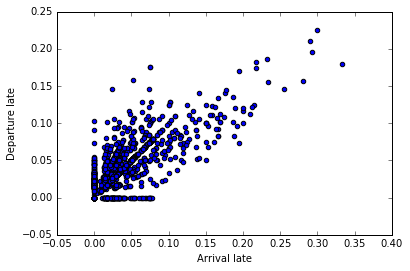

In [11]:
plt.scatter(df['arrival_late_pct'], df['departure_late_pct'])
#plt.scatter(df['arrival_early_pct'], df['departure_early_pct'])
plt.xlabel('Arrival late')
plt.ylabel('Departure late')

1
2
3
4
5
6
7


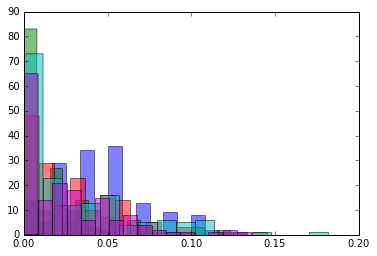

In [12]:
good_samples = df[df['num_trips'] > SMALL_N_THRESHOLD]
today = good_samples[2 == good_samples['week_day']]
for day in xrange(1, 8):
    print day
    today = good_samples[day == good_samples['week_day']]
    if len(today) > 0:
        plt.hist(today['departure_late_pct'].values, bins=16, alpha=0.5)
plt.show()

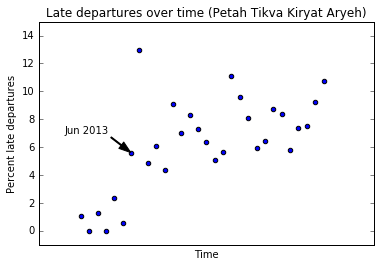

In [18]:
# Generate time series plot of late departures
route_id = 100
if os.path.isfile("%scache_%s.json" % (CACHE_PATH, route_id)):
    with open("%scache_%s.json" % (CACHE_PATH, route_id), 'r') as input_file:
        route_data = json.load(input_file)

data_for_plot = pd.DataFrame()
for time, data in route_data:
    data_for_plot_all = []
    for entry in data:
        # info : {u'hours', u'num_trips', u'week_day'}
        # stops : [{u'arrival_on_time_pct', u'arrival_late_pct', 
        #           u'departure_early_pct', u'departure_on_time_pct',
        #           u'stop_id', u'arrival_early_pct', u'departure_late_pct'}]
        if ('all' == entry['info']['week_day'] and 'all' == entry['info']['hours']):
            for stops in entry['stops']:
                if stops['stop_id'] == 4170:
                    tmp = pd.DataFrame({'time':datetime.datetime(time[0], time[1], 1),
                                        'departure_late_pct':stops['departure_late_pct']*100},
                                        index=[0])
                    data_for_plot = data_for_plot.append(tmp)
                    
data_for_plot = data_for_plot.sort_values('time')

plt.scatter(xrange(len(data_for_plot)), data_for_plot.sort_values('time')['departure_late_pct'].values)
plt.annotate('Jun 2013', xy=(6, 5.6), xytext=(-2, 7),
            arrowprops=dict(facecolor='black', shrink=0.01, width=1, headwidth=8))
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Percent late departures')
plt.ylim([-1, 15])
plt.title('Late departures over time (Petah Tikva Kiryat Aryeh)')

In [75]:
data_for_plot.reset_index().head(100)

,index,departure_late_pct,time
0,0,1.052632,2013-01-01
1,0,0.000000,2013-02-01
2,0,1.257862,2013-03-01
3,0,0.000000,2013-04-01
4,0,2.339181,2013-05-01
5,0,0.534759,2013-06-01
6,0,5.612245,2013-07-01
7,0,12.969283,2013-08-01
8,0,4.888889,2013-09-01
9,0,6.097561,2013-10-01
